In [1]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score,accuracy_score,confusion_matrix
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.manifold import MDS
from sklearn.preprocessing import Imputer,StandardScaler,MinMaxScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
import seaborn as sns
from xgboost.sklearn import XGBClassifier
from WeightofEvidence import WoE
from __future__ import division
%matplotlib inline

/home/aleespa/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
X = pd.read_csv('S&P500_2017.csv')
X = X.drop(['Date'],axis=1)

In [3]:
X.head()

,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,...,XL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
0,46.074703,45.816051,170.237915,113.847588,59.784031,80.855621,37.982937,114.158501,103.480003,70.577911,...,36.900692,57.513260,86.670731,58.296070,26.833357,48.875042,61.848686,102.513084,42.586197,53.118965
1,46.679256,46.211868,171.634933,113.720161,60.626999,82.862099,38.284462,114.432961,104.139999,70.431908,...,37.027840,57.094593,85.717155,58.773418,27.845938,49.603493,62.073734,103.455551,43.197666,53.634392
2,46.124260,45.410336,171.515182,114.298462,61.086800,81.902901,38.615170,112.717552,105.910004,69.419624,...,36.607288,56.403305,84.439362,58.007671,27.729099,49.150673,62.279217,104.120262,42.497429,53.455975
3,47.561314,45.726990,169.269974,115.572708,61.105961,82.999107,39.665661,114.001671,108.300003,69.692154,...,36.568165,57.493786,84.391678,57.967899,27.300703,48.806133,63.032623,104.130180,42.773582,53.624477
4,47.709969,46.587898,169.170197,116.631294,61.508286,83.664680,39.626755,112.727356,108.570000,70.023094,...,35.952015,57.503525,82.999451,58.146900,27.144920,48.599411,63.208748,106.154053,42.310051,53.475800


In [4]:
r = 0.035/365
n = 5000

In [5]:
Times = [(t1,t1+np.random.choice(range(1,30))) for t1 in [np.random.choice(range(220))for _ in range(n)] ]

In [6]:
M=X.fillna(X.mean())
M = M.pct_change()
Z = pd.DataFrame(columns=M.columns)
Z = Z.T
Z['Mean'] = M.mean()
Z['Std'] = M.std()
Z['Skew'] = M.skew()
Z['Kurt'] = M.kurt()

$$K=S_0e^{rt}$$

In [7]:
Y = pd.DataFrame(columns=['Mean','Std','Skew','Kurt','t','D'],index=range(n))
for i in range(n):
    ran = np.random.choice(503)
    t = (Times[i][1]-Times[i][0])
    S0 = X.T.iloc[ran][Times[i][0]]
    K = S0*np.e**(r*t)
    St =  X.T.iloc[ran][Times[i][1]] 
    d=  (K <=St)*1
    Y.iloc[i]=list(Z.iloc[ran])+[Times[i][1]-Times[i][0],d]

In [8]:
Y.head()

,Mean,Std,Skew,Kurt,t,D
0,0.0130245,0.260683,14.7127,229.654,11,0
1,0.000882998,0.0124772,-0.36919,2.84803,15,0
2,0.00166764,0.0112907,-0.0591882,12.1216,10,1
3,0.00190944,0.0124115,1.99997,19.5792,11,0
4,0.00102666,0.0111468,-0.337393,3.70648,26,1


In [9]:
for col in Y.columns:
    Y[col] = Y[col].apply(pd.to_numeric, errors='coerce')

In [10]:
W = Y[['Mean','Std','Skew','Kurt','t']]
y = Y[['D']]

In [11]:
woe = WoE(disc = [],cont=['t','Mean','Std','Skew','Kurt'])
woe.fit(W,y,bins=range(2,50))
Ww = woe.transform(W)
woe.IV

,Mean,Std,Skew,Kurt,t
0,0.249733,0.108364,0.081428,0.057175,0.03388


In [12]:
Xt,Xv,yt,yv =train_test_split(Ww,y,train_size=0.7)
for d in [Xt,Xv,yt,yv]:
    print d.shape

(3500, 5)
(1500, 5)
(3500, 1)
(1500, 1)


/home/aleespa/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [13]:
def metricas(model,Xt,Xv,yt,yv):
    print roc_auc_score(y_score=model.predict_proba(Xt)[:,1],y_true=yt)
    print roc_auc_score(y_score=model.predict_proba(Xv)[:,1],y_true=yv)
    print accuracy_score(y_pred=model.predict(Xt),y_true=yt)
    print accuracy_score(y_pred=model.predict(Xv),y_true=yv)
    print confusion_matrix(y_pred=model.predict(Xt),y_true=yt)
    print confusion_matrix(y_pred=model.predict(Xv),y_true=yv)

In [14]:
model =LogisticRegression()
model.fit(Xt,yt)
metricas(model,Xt,Xv,yt,yv)

/home/aleespa/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.652480279207
0.639580001429
0.616857142857
0.635333333333
[[ 562  946]
 [ 395 1597]]
[[237 384]
 [163 716]]


In [15]:
from sklearn.tree import DecisionTreeClassifier
param_grid = dict(criterion=['gini','entropy'],
                 max_depth=range(1,11),
                 min_samples_split = range(100,210,10)
                 )
model = DecisionTreeClassifier()
grid = GridSearchCV(cv=10,n_jobs=-1,scoring='roc_auc',
                    estimator=model,
                    param_grid=param_grid)


grid.fit(Ww,y)

print grid.best_estimator_
print grid.best_params_
print grid.best_score_

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=200,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
{'min_samples_split': 200, 'criterion': 'entropy', 'max_depth': 4}
0.623075537112


In [16]:
model = grid.best_estimator_
metricas(model,Xt,Xv,yt,yv)

0.605499584545
0.602721581947
0.613142857143
0.616666666667
[[ 664  844]
 [ 510 1482]]
[[279 342]
 [233 646]]


In [20]:
xgb = XGBClassifier()
xgb.fit(Ww,y)
metricas(xgb,Xt,Xv,yt,yv)

0.679068562047
0.668151482343
0.634285714286
0.649333333333
[[ 602  906]
 [ 374 1618]]
[[239 382]
 [144 735]]


In [18]:
pca = PCA(n_components=2)
sc = StandardScaler()
sc.fit(Ww)
Ws =  pd.DataFrame(sc.transform(Ww),columns=Ww.columns)
pca.fit(Ws)
Wp = pd.DataFrame(pca.transform(Ws),columns=['p1','p2'])
Wp['c']=y

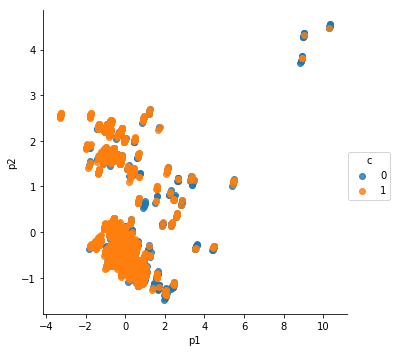

In [19]:
sns.lmplot(data=Wp,x='p1',y='p2',fit_reg=False,hue='c')